**Import**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

!pip install transformers
!pip install -U datasets

from collections import defaultdict, Counter
import json
import torch

from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader

Mounted at /content/gdrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you ha

In [ ]:
banktrak_df = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/word_count.csv')
model_path = "/content/gdrive/MyDrive/DSSI/distilbert-model"

**Import For Class Imbalance**

In [ ]:
# #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler
# from imblearn.over_sampling import RandomOverSampler

# X = banktrak_df_1[['text']]
# y = banktrak_df_1[['contains_debt_instrument_information']]

# #oversampling minority data
# ros = RandomOverSampler(random_state=42)                 #this is the random oversampling
# X_resampled, y_resampled = ros.fit_resample(X, y)        #i think this is fitting our model with the undersampling
# y_resampled.contains_debt_instrument_information.value_counts()

# X_resampled = X_resampled.reset_index(drop=True)
# y_resampled = y_resampled.reset_index(drop=True)

# banktrak_df = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# #https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# from imblearn.under_sampling import RandomUnderSampler

# X = banktrak_df_1[['text']]
# y = banktrak_df_1[['contains_debt_instrument_information']]

# #oversampling minority data
# rus = RandomUnderSampler(random_state=42)                 #this is the random oversampling
# X_resampled, y_resampled = rus.fit_resample(X, y)        #i think this is fitting our model with the undersampling
# y_resampled.contains_debt_instrument_information.value_counts()

# X_resampled = X_resampled.reset_index(drop=True)
# y_resampled = y_resampled.reset_index(drop=True)

# banktrak_df = pd.concat([X_resampled, y_resampled], axis=1)

**train_test_split + Dataset**



In [ ]:
#split data into train and validation
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(banktrak_df, test_size=0.2, random_state=42) #validation size is 20%, random state is just there for reproducilbility

# turn to json dict
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'train': Dataset.from_pandas(train_df), 'validation': Dataset.from_pandas(val_df)}) #use dataset dict to turn to dataframe to dict

**Tokenizer**

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM #import auto tokenizer, and auto model

#adding tokenizer and model to variable
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModelForMaskedLM.from_pretrained("allenai/longformer-base-4096")

#testing tokenizer
sample_input = "We want to use a pretrained tokenizer."
tokenized_inputs = tokenizer(sample_input, return_tensors = "pt")
print(tokenized_inputs["input_ids"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

tensor([[    0,   170,   236,     7,   304,    10, 11857, 26492, 19233,  6315,
             4,     2]])


In [ ]:
#apply tokenizer to dataset
tokenized_dataset = dataset.map(lambda example: tokenizer(example['text'], padding="max_length", truncation=True, max_length=1024 ))

#clean up dataset
tokenized_dataset = tokenized_dataset.remove_columns(['item', 'text', 'company','cik'])
tokenized_dataset = tokenized_dataset.rename_column("contains_debt_instrument_information", "labels") #rename this column labels bz the model likes that
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

**DataLoader To Batch Data**





In [ ]:
#making variables for train and eval dataset
train_dataset = tokenized_dataset['train'].shuffle(seed=1111)
eval_dataset = tokenized_dataset['validation']

#putting train and eval into dataloader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=False)

**Training And Validation Model**

In [ ]:
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from transformers import set_seed
from torch.optim import AdamW

#set seed and device
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model call
model = AutoModelForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2).to(device)

num_epochs = 1
num_training_steps = len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs): #for num of epochs
    # training
    model.train() # training mode
    training_losses = [] #store batch losses
    for batch_i, batch in enumerate(train_dataloader): #for batches in training loader

        optimizer.zero_grad() # prevents gradients from increasing

        # copy input to device
        input_ids = batch['input_ids'].to(device)            #moves these to same device
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels= labels.long()


        # Call the model for Forward Pass
        output = model(input_ids = input_ids, attention_mask = attention_mask, labels =labels)
        training_loss = output.loss
        training_losses.append(training_loss.item())                          #adds loss data

        #Do backprop and update params by taking an optimization step
        training_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    print("Mean Training Loss", np.mean(training_losses))

    # validation
    val_loss = 0
    #set to evaluation mode
    model.eval()
    for batch_i, batch in enumerate(eval_dataloader):                  #go over batches
        with torch.no_grad():                                          #clear gradients
            # copy input to device
            input_ids = batch['input_ids'].to(device)                  #add to device
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            labels = labels.long()

            #call the model again for Forward Pass
            output = model(input_ids = input_ids, attention_mask = attention_mask, labels =labels)

        # add the batch average of validation loss to the running sum
        val_loss += output.loss               # batch’s loss to the total validation loss.

    # calculating average validation loss across all batches
    avg_val_loss = val_loss / len(eval_dataloader)                               #calculations of best loss
    print(f"Validation loss: {avg_val_loss}")

    # Saving this model checkpoint only if the current validation loss
    # is better than the best validation loss obtained so far
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),'val_loss': best_val_loss,}, f"{model_path}epoch_{epoch}.pt")
    print()

print(f"The best validation loss after {num_epochs} epochs is: {best_val_loss}")

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/82 [00:00<?, ?it/s]

Initializing global attention on CLS token...


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

Mean Training Loss 0.5820560784238141
Validation loss: 0.5335460901260376
Saving checkpoint!

The best validation loss after 1 epochs is: 0.5335460901260376


**Evaluate Model**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=len(tokenized_dataset['validation']))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_batch_logits = []    #store models raw outputs logits
y_true = []
for batch_i, batch in enumerate(eval_dataloader): #go through batches
    with torch.no_grad():                          #clear graidnet
        # copy input to device
        input_ids = batch['input_ids'].to(device)            #add to deviice
        attention_mask = batch['attention_mask'].to(device)  #add device
        labels = batch['labels'].cpu().detach().numpy()      #removes labels

        # Call the model on test data
        output = model(input_ids = input_ids, attention_mask = attention_mask, labels =None)
        test_batch_logits.append(output.logits)                #append output logits --stores logits before soft max
        y_true.extend(labels)                                  #add ground turth labels

print(len(test_batch_logits),len(eval_dataloader))      #shape of the final logits tensor ([num_examples, num_classes])
test_logits = torch.cat(test_batch_logits, dim=0)     #concatenates the logits from all batches along dimension 0.

#sanity check -> dimension 0 of your logits tensor should be same as the size of the test dataset
print(test_logits.shape,len(tokenized_dataset['validation']),len(y_true))

1 1
torch.Size([44, 2]) 44 44


In [ ]:
#Convert the logits to predicted labels
y_pred = torch.argmax(test_logits, dim = 1).cpu().numpy()

print(y_true[:10])
print(y_pred[:10])

#sanity check: should have as many predictions as labels
assert len(y_pred)==len(y_true)

[np.False_, np.True_, np.True_, np.True_, np.True_, np.True_, np.False_, np.False_, np.True_, np.True_]
[0 1 1 1 0 1 1 1 1 1]


In [ ]:
# call the f1_score function
print('F1 Score:',f1_score(y_true, y_pred, average='binary')) #why add average binary?

# call the accuracy_score function
print('Accuracy Score:',accuracy_score(y_true, y_pred))

from sklearn.metrics import precision_score, recall_score
print('Precision Score:',precision_score(y_true, y_pred))
print('Recall Score:',recall_score(y_true, y_pred))

F1 Score: 0.84375
Accuracy Score: 0.7727272727272727
Precision Score: 0.75
Recall Score: 0.9642857142857143


**Visualize**

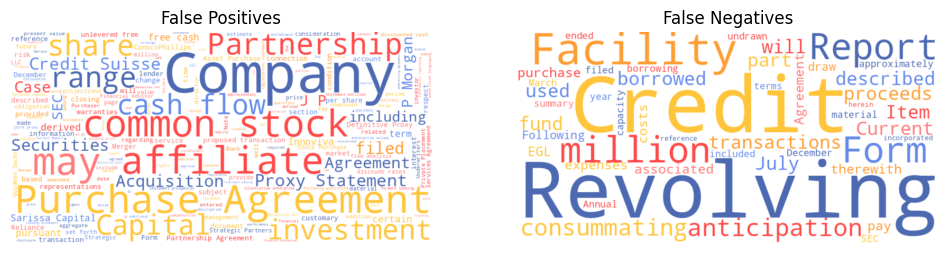

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import random

company_stopwords = set(["Enstar", "ConocoPhillips", "Concho", ])  # extend as needed
stopwords = STOPWORDS.union(company_stopwords)

custom_colors = ["#4c69b2", "#ff4949", "#ff7a78", "#ff9d35", "#6389eb", "#ffc53a"]

def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return random.choice(custom_colors)

fp = csv_file[(csv_file["y_pred"] == 1) & (csv_file["y_true"] == 0)]
fn = csv_file[(csv_file["y_pred"] == 0) & (csv_file["y_true"] == 1)]

# Combine all FP/FN texts
fp_text = " ".join(fp['text'])  # Replace with your FP texts
fn_text = " ".join(fn['text'])  # Replace with your FN texts

# Generate word clouds
wordcloud_fp = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, color_func=random_color_func).generate(fp_text)
wordcloud_fn = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, color_func=random_color_func).generate(fn_text)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fp, interpolation='bilinear')
plt.title('False Positives')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.title('False Negatives')
plt.axis('off')
plt.show()

In [ ]:
# pip install transformer-ranker

In [ ]:
# from datasets import load_dataset
# from transformer_ranker import TransformerRanker, prepare_popular_models

# # Step 1: Load the CoNLL-03 dataset from HuggingFace
# dataset = load_dataset('conll2003')

# # Step 2: Use our list of 17 'base' LMs as candidates
# language_models = prepare_popular_models('base')

# # Step 3: Initialize the ranker with the dataset
# ranker = TransformerRanker(dataset, dataset_downsample=0.2)

# # ... and run the ranker to obtain the ranking
# results = ranker.run(language_models, batch_size=64)

# # print the ranking
# print(results)